In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import math
import operator
import collections
import itertools
import ast
from tqdm import tqdm
import random
from mpl_toolkits.basemap import Basemap

# For importing functions
import ipynb
import sys  

# Import data
sys.path.insert(0, 'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Extraction_Partitioning_Functions')

from ipynb.fs.full.Data_Extraction_Functions import three_month_extraction,five_month_extraction,extract_region_lists

# Import partitioning functions
from ipynb.fs.full.Partitioning_Functions import regional_ordinal_sequence,block_ordinal_sequence

# Cross-Link Counting Functions

In [2]:
def ordpat_strings(time_series,window_length,embedding_delay,block=False):
    if block==False:
        regional_sequence = regional_ordinal_sequence(time_series,window_length,embedding_delay)
    
        nw_ord = [str(i) for i in regional_sequence[0]]
        ne_ord = [str(i) for i in regional_sequence[1]]
        mc_ord = [str(i) for i in regional_sequence[2]]
        io_ord = [str(i) for i in regional_sequence[3]]
        eep_ord = [str(i) for i in regional_sequence[4]]
        ism_ord = [str(i) for i in regional_sequence[5]]
        easm_ord = [str(i) for i in regional_sequence[6]]
        
        if len(nw_ord) == len(ne_ord) == len(mc_ord) == len(io_ord) == len(eep_ord) == len(ism_ord) == len(easm_ord):
            return  np.asarray((nw_ord,ne_ord,mc_ord,io_ord,eep_ord,ism_ord,easm_ord))
        else:
            print('Data Error. Ordinal sequences are not of the same length and therefore cannot fully be coupled together')
    
    elif  block==True:
        regional_sequence  = block_ordinal_sequence(time_series,window_length)
        
        nw_ord = [str(i) for i in regional_sequence[0]]
        ne_ord = [str(i) for i in regional_sequence[1]]
        mc_ord = [str(i) for i in regional_sequence[2]]
        io_ord = [str(i) for i in regional_sequence[3]]
        eep_ord = [str(i) for i in regional_sequence[4]]
        ism_ord = [str(i) for i in regional_sequence[5]]
        easm_ord = [str(i) for i in regional_sequence[6]]
        
        
        if len(nw_ord) == len(ne_ord) == len(mc_ord) == len(io_ord) == len(eep_ord) == len(ism_ord) == len(easm_ord):
            return  np.asarray((nw_ord,ne_ord,mc_ord,io_ord,eep_ord,ism_ord,easm_ord))
        else:
            print('Data Error. Ordinal sequences are not of the same length and therefore cannot fully be coupled together')

In [3]:
def co_occur(region1,region2):
    N = len(region1) # Since length of all ordinal sequences are the same 
    
    co_occur_join = []
    for i in range(N):
        #joined = region1[i] + region2[i]
        joined = (region1[i],region2[i])
        co_occur_join.append(joined)
    
    return co_occur_join

In [4]:
def count_frequency(input_list,highest_freq=True):
    '''
    Count frequency of each unique element in input_list
    '''
    freq = {} # Create empty dictionary
    for item in input_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    if highest_freq==True:
        return dict(sorted(freq.items(),key = operator.itemgetter(1),reverse=True))
    else:
        return freq

In [5]:
# Find how progression between ordinal patterns occurs
# Eg) For each occurrence of [0 1 2 3 4] in region 1, pattern [4 3 2 1 0] occurs x times, [0 2 4 1 3] occurs y times in region 2
def co_occur_frequency(region1,region2,pattern_length,greater_than_value,show_zero=False):
    '''
    Find how each pattern in the ordinal sequence of region1 is distributed amonst the co-occurrences in region2
    
    Inputs:
        region1 = ordinal sequence for first region
        region2 = ordinal sequence for second region
        pattern_length = length of the ordinal pattern of interest
        greater_than_value = filter dictionary by co-occurrence greater than or equal to this value
        show_zero = True -> show all (pattern_lenth!)**2 pattterns including those which occur 0 times
                    False ->  only show patterns which occur >0 times
        
    Returns:
        List of dictionaries with distribution of each ordinal pattern co-occurrence
    '''
    admissible = [''.join(str(list(i)).split(',')) for i in  list(itertools.permutations([i for i in range(pattern_length)]))]
    admissible_co_occurrences = list(itertools.product(admissible, repeat=2))
    
    test = co_occur(region1, region2)
    freqs = count_frequency(test)
    
    if show_zero==False:
        filtered_dict = {k: v for (k,v) in freqs.items() if v >= greater_than_value}
        #return sorted(filtered_dict.items())
        return filtered_dict
    else:
        for i in range(len(admissible_co_occurrences)):
            potential = admissible_co_occurrences[i]
            if potential not in freqs.keys():
                freqs[potential] = 0
        return sorted(freqs.items())

# Import Data

In [6]:
# 3 month
# djf starts from December 1763
# jja starts from June  1763

# 5 month
# ndjfm starts from November 1763
# mjjas starts from May 1763

In [7]:
three_month = extract_region_lists(three_month=True)
djf_dates = three_month[0]
jja_dates = three_month[1]
three_monthly = three_month[2:]

five_month = extract_region_lists(three_month=False)
ndjfm_dates = five_month[0]
mjjas_dates = five_month[1]
five_monthly = five_month[2:]

names = ['NW Aus', 'NE Aus', 'MC', 'IO', 'EEP', 'ISM', 'EASM']
regions = [i for i in range(7)]

DJF/JJA Order: DJF_dates,JJA_dates,nw,ne,mc,ioo,eep,ism,easm
Length of time series with minor temporal irregularities: 753
Number of missing months: 21
Length of time series with no temporal irregularities: 720
NDJFM/MJJAS Order: NDJFM_dates,MJJAS_dates,nw,ne,mc,ioo,eep,ism,easm


# Finding statistically significant climate couplings between monsoon regions

In [8]:
def cross_links_simple(region_1,region_2,window_length,co_occurring_threshold):
    '''
    Calculate the number of co-occurring patterns
    
    Inputs:
        1) ordinal_sequence_region_1 = ordinal sequence corresponding to region 1 (the result of regional_ordinal_sequence() or block_ordinal_sequence())
        2) ordinal_sequence_region_2 = ordinal sequence corresponding to region 2
        3) window_length = ordinal partition window length, D corresponding to the sequence above
        4) co_occurrence_threshold = threshold for a co-occurring pattern to be prescribed
    '''  
    freqs = co_occur_frequency(region_1,region_2,window_length,co_occurring_threshold,False)
    #print(freqs)
    coupling_strength = len(freqs)
    
    return coupling_strength

In [9]:
def white_noise_surrogates(original_data):
    '''
    Return a shuffled copy of a time series array.

    Each time series is shuffled individually. The surrogates correspond to
    realizations of white noise consistent with the :attr:`original_data`
    time series' amplitude distribution.
    '''
    
    shuffle = random.shuffle
    surrogate = original_data.copy()
    for i in range(surrogate.shape[0]):
        shuffle(surrogate[i,:])
    return surrogate

In [10]:
def chopped_surrogate_testing(region_input,n_trials,window_length,co_occur_threshold): # Input original region_input (function applies chopped_surrogate())
    print('Using "white_noise_surrogates" algorithm.')
    n_tests = 21

    test_distribution = np.zeros((n_tests+1,n_trials))
    
    for i in tqdm(range(n_trials)):
        surrogate_input = white_noise_surrogates(region_input)
        counter = 0
        for a,b in itertools.combinations(regions,2):
            count = cross_links_simple(surrogate_input[a],surrogate_input[b],window_length,co_occur_threshold)
            counter +=1 
            test_distribution[counter][i] = count
            
    test_distribution = np.delete(test_distribution,0,0)
    
    return test_distribution

In [11]:
def return_statistical_significance(actual_results,test_results,sig_level): # Actual = actual time series, theory = simulation surrogates
    names = ['NW','NE','MC','IO','EEP','ISM','EASM']
    permutation_names = []
    for i,j in itertools.combinations(regions,2):
        name = [names[i],names[j]]
        permutation_names.append(name)
    
    region_compare_percentile = []
    for i in range(len(test_results)):
        percentile = np.percentile(test_results[i],sig_level)
        region_compare_percentile.append(percentile)
    
    synchronisation = []
    for i in range(len(test_results)):
        #if region_compare_percentile[i] <= actual_results[i]:
        if region_compare_percentile[i] >= actual_results[i]:
            synchronisation.append(1)
        else:
            synchronisation.append(0)
    return list(zip(permutation_names,synchronisation))

In [12]:
def connections_summary_for_plot(connections_raw):
    connections_test = []
    edge_from_test = []
    edge_to_test = []
    for i in range(len(connections_raw)):
        if connections_raw[i][1] == 1:
            begin = connections_raw[i][0][0]
            end = connections_raw[i][0][1]
            value = 1
            
            edge_from_test.append(begin)
            edge_to_test.append(end)
            connections_test.append(value)
        else:
            pass
    return edge_from_test,edge_to_test

In [13]:
def nodes_latlon_dict():
    m = Basemap(projection = 'merc',
            llcrnrlat=-40,
            llcrnrlon=40,
            urcrnrlat=40,
            urcrnrlon=260,
            resolution='l') #requires initialisation of the map
    
    region_names = ['NW','NE','MC','IO','EEP','ISM','EASM']
    region_lat = [-15.000000,-15.000000,-2.500000,-7.500000,5.000000,15.000000,15.000000]
    region_lon = [127.500000,145.000000,120.000000,52.500000,240.000000,85.000000,110.000000]
    mx,my = m(region_lon,region_lat)
    
    coords =list(tuple(zip(mx,my)))
    pos = dict(zip(region_names,coords))
    
    return pos

In [14]:
def network_map_plot(connections_summary_input):
    pos = nodes_latlon_dict()
    test_graph = connections_summary_for_plot(connections_summary_input)
    
    m = Basemap(projection = 'merc',
            llcrnrlat=-40,
            llcrnrlon=40,
            urcrnrlat=40,
            urcrnrlon=260,
            resolution='l')
   
    G = nx.Graph()
    
    for i in range(len(test_graph[0])):
        begin = test_graph[0][i]
        end = test_graph[1][i]
        G.add_edge(begin,end)
    
    plt.figure(figsize=(12,15))
    
    nx.draw_networkx(G,pos,node_size=100,node_color='red',with_labels=False,width=1.5)
    
    m.drawcoastlines(linewidth=0.5)
    m.drawparallels(np.arange(-40.,41.,10.),
                    labels=[True,True,False,False],
                    dashes=[2,2],
                    linewidth=0.0)
    m.drawmeridians(np.arange(40.,260.,20.),
                    labels=[False,False,False,True],
                    dashes=[2,2],
                    linewidth=0.0)
    plt.show();

### Window length 5 

In [15]:
patterns_5 = ordpat_strings(five_monthly,5,1,block=True)

In [36]:
n_trials = 20000
window_length = 5
co_occur_threshold = 1

actual_results_5 = []
for i,j in itertools.combinations(regions,2):
    num = cross_links_simple(patterns_5[i],patterns_5[j],window_length,co_occur_threshold)
    actual_results_5.append(num)

test_results_5 = chopped_surrogate_testing(patterns_5,20000,5,1)

Using "white_noise_surrogates" algorithm.


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [14:11<00:00, 23.50it/s]


(['NW', 'NE'], 0)
(['NW', 'MC'], 0)
(['NW', 'IO'], 1)
(['NW', 'EEP'], 1)
(['NW', 'ISM'], 1)
(['NW', 'EASM'], 1)
(['NE', 'MC'], 1)
(['NE', 'IO'], 1)
(['NE', 'EEP'], 1)
(['NE', 'ISM'], 0)
(['NE', 'EASM'], 1)
(['MC', 'IO'], 1)
(['MC', 'EEP'], 0)
(['MC', 'ISM'], 0)
(['MC', 'EASM'], 1)
(['IO', 'EEP'], 0)
(['IO', 'ISM'], 0)
(['IO', 'EASM'], 0)
(['EEP', 'ISM'], 1)
(['EEP', 'EASM'], 0)
(['ISM', 'EASM'], 1)


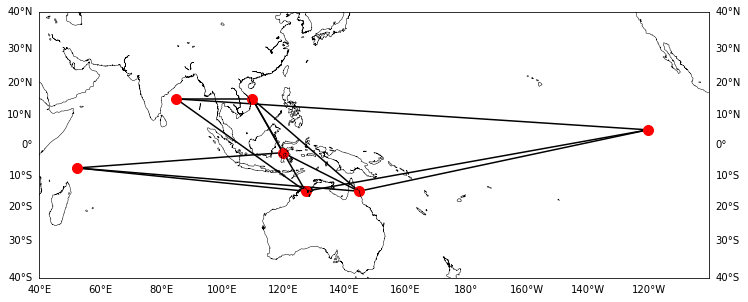

In [37]:
stat_results_5 = return_statistical_significance(actual_results_5,test_results_5,30)
for i in range(len(stat_results_5)):
    print(stat_results_5[i])
network_map_plot(stat_results_5)

### Window length 3 

In [19]:
patterns_3 = ordpat_strings(three_monthly,3,1,block=True)

In [38]:
window_length = 3

actual_results_3 = []
for i,j in itertools.combinations(regions,2):
    num = cross_links_simple(patterns_3[i],patterns_3[j],window_length,co_occur_threshold)
    actual_results_3.append(num)

test_results_3 = chopped_surrogate_testing(patterns_3,20000,window_length,co_occur_threshold)

Using "white_noise_surrogates" algorithm.


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [03:15<00:00, 102.39it/s]


(['NW', 'NE'], 0)
(['NW', 'MC'], 0)
(['NW', 'IO'], 0)
(['NW', 'EEP'], 1)
(['NW', 'ISM'], 0)
(['NW', 'EASM'], 0)
(['NE', 'MC'], 0)
(['NE', 'IO'], 0)
(['NE', 'EEP'], 0)
(['NE', 'ISM'], 1)
(['NE', 'EASM'], 0)
(['MC', 'IO'], 1)
(['MC', 'EEP'], 1)
(['MC', 'ISM'], 0)
(['MC', 'EASM'], 0)
(['IO', 'EEP'], 0)
(['IO', 'ISM'], 1)
(['IO', 'EASM'], 0)
(['EEP', 'ISM'], 1)
(['EEP', 'EASM'], 1)
(['ISM', 'EASM'], 1)


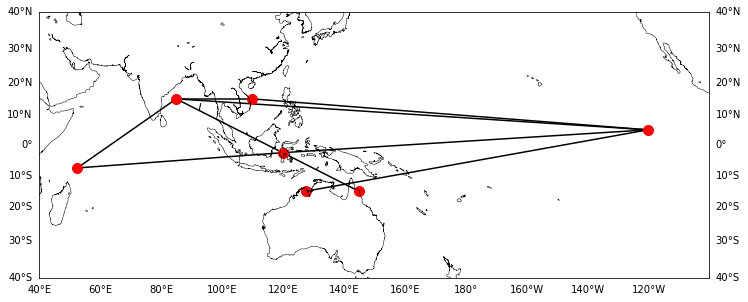

In [41]:
stat_results_3 = return_statistical_significance(actual_results_3,test_results_3,20)
for i in range(len(stat_results_3)):
    print(stat_results_3[i])
network_map_plot(stat_results_3)